Universidad de Costa Rica  <br>
CI-0148 Aprendizaje Máquina <br>
Período: 2022-I <br>
Docente: Pablo Sauma Chacón <br>
Estudiantes: 

- Jose Pablo Mora Villalobos. B85326 
- Juan José Valverde Campos. B47200 
***

# Laboratorio 4

Objetivo: Familiarizar al estudiante con la creación y el uso de redes neuronales desde una perspectiva de modelo matemático.

[Descripción del laboratorio](https://docs.google.com/document/d/1wRx9fXTOqUEHyD78Mwrd8F8RDaTmvm9yBhxixX-VNsY/edit)

## 1. Importación de Librerías

In [3]:
import numpy as np
from scipy.special import expit
import pandas as pd 
from sklearn.model_selection import PredefinedSplit, train_test_split

## 2. Implementación de funciones de activación

Las funciones `sigmoid()` y `tanh()` fueron resueltas con `numpy`, pero para evitar problemas de *overflow* con algunos valores cuando los resultados de `np.exp(x)` son `inf`, se decidió usar los métodos `expit()` y `np.tanh()` respectivamente.

In [5]:
def sigmoid(x):
    # 1/(1 + e^(-x))
    # return 1 / (1 + np.exp(-x)) 
    return expit(x)

def d_sigmoid(y):
    return y*(1-y)

def tanh(x):
    #  (e^x - e^(-x))/(e^x + e^(-x))
    # return (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))
    return np.tanh(x)

def d_tanh(y):
    return 1 - y**2

def relu(x):
    # (x if x>0 else 0)
    return np.where(x > 0, x, 0)

def d_relu(y):
    return np.where(y > 0, 1, 0)

def lrelu(x):
    # (x if x>0 else 0.01x)
    return np.where(x > 0, x, 0.01 * x)

def d_lrelu(y):
    return np.where(y > 0, 1, 0.01 )


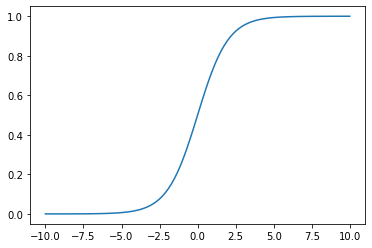

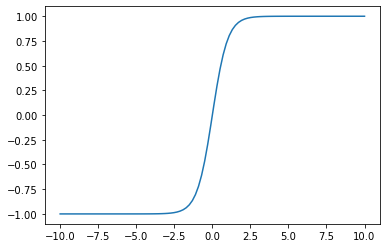

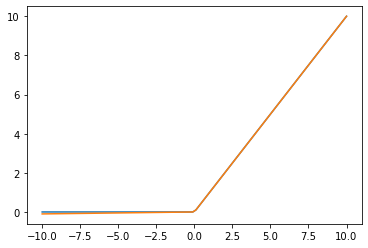

In [6]:
n = np.linspace(-10,10,100)
import matplotlib.pyplot as plt

x = np.array([-np.inf, -1.5, 0, 1.5, np.inf])
plt.plot(n,expit(n))
plt.show()
plt.plot(n,np.tanh(n))
plt.show()
plt.plot(n,relu(n))
plt.plot(n,lrelu(n))
plt.show()



# 3. Creación de clase DenseNN

In [7]:

activations = {'s':sigmoid,'t':tanh,'r':relu,'l':lrelu}
activationsD = {'s':d_sigmoid,'t':d_tanh,'r':d_relu,'l':d_lrelu}
class DenseNN:

    def __init__(self, layers, activation, seed=0):
        '''
        Se realiza la inicialización de la clase
        '''
        # Se comprueba que se pueda realizar una red neuronal
        try:
            if len(layers) < 3:
                raise Exception("Las capas tienen que ser mayor a 3.")
        except:
            print('El parámetro layers no es un vector.')
            return
        
        np.random.seed(seed) # Se implanta la semilla para la replicación de la prueba
        self._set_structure(layers) # Se crea la estructura de red neuronal brindada por el usuario
        self._set_activation(activation) # Se crean las funciones de activación solicitadas por cada capa 

    def MSE(self,y_true, y_predict):
        '''
        Funcion del error medio cuadratico
        '''
        return np.mean(np.power((y_true - y_predict),2))

    def GDMSE(self,y_predict,y_true):
        '''
        Función de la derivada del del error medio absoluto
        '''
        return (2*(y_predict-y_true))

    def _set_structure(self, layers):
        '''
        Se inicializan la matriz de pesos, así como los valores netos, de activación y errores de cada capa
        '''
        weights, netValues,activationValues,errors = [],[],[],[]
        for i in range(len(layers)-1): # Se itera por cada una de las capas
            shape = ((layers[i] + 1) , layers[i+1]) # Se obtiene el shape necesario para poder crear la matriz de pesos
            weights.append(np.random.normal(size=shape,loc=0,scale=2)) # Se inicializa los pesos siguiendo la inicialización de Xavier
            netValues.append(np.zeros(layers[i+1]+1)) # Se agregan valores netos para las neuronas de la capa correspondiente, donde se inicializan en 0
            activationValues.append(np.zeros(layers[i+1]+1)) # Se agregan valores de activación para las neuronas de la capa correspondientes, donde se inicializan en 0
            errors.append(np.zeros(layers[i+1])) # Se agregan los errores para las neuronas de la capa correspondiente, donde se inicializan en 0
        # Se asigna todo lo creado como atributos de la clase correspondiente
        self.weights = weights
        self.netValues = netValues
        self.activationValues = activationValues
        self.errors = errors

    def _set_activation(self,activation):
        '''
        Se agregan las funciones de activación
        '''
        self.activation = []
        self.activationD = []
        for key in activation:
            self.activation.append(activations[key]) # Corresponde a la función de activación
            self.activationD.append(activationsD[key]) # Corresponde a la derivada de la función de activación

    def predict(self, x):
        '''
        Se realiza la predicción bajo unos valores X dados por el ususario
        Aquí se retorna una matriz nxp 
            Donde n es la cantidad de observaciones 
            p son las salidas de la ultima capa
        '''
        x = np.insert(np.asarray(x), x.shape[1], 1, axis=1) # Se obtiene los valores como numpy en x y además se agrega el bias correspondiente
        for i in range(len(self.activation)):
            self.netValues[i] = x @ self.weights[i] # Se obtiene los valores netos por medio de una multiplicación matricial
            self.activationValues[i] = self.activation[i](self.netValues[i]) # A esos valores netos se les pasa una función de activación
            self.activationValues[i] = np.insert(np.asarray(self.activationValues[i]), self.activationValues[i].shape[1], 1, axis=1) 
            # Se utilizaran los valores de activacion como nuevas entradas, por lo que se pasan los mismos con el extra de el bias que seguira a posteriori
            x = self.activationValues[i]
        self.activationValues[-1] = np.delete(self.activationValues[-1],self.activationValues[-1].shape[1]-1,1) # Al ultimo valor de activación se le elimina el bias, dado que no es necesario
        return self.activationValues[-1] # Se retorna los resultados finales, donde los últimos valores de activación seran las respuestas del y estimado.
    
    def train(self, lr=0.05, momentum=0, decay=0):
        '''
        Se setean los hiperparámetros respectivos a:
            1. lr = Learning Rate
            2. Momentum 
            3. Decay
            4. Cantidad de epocas
            5. Las derivadas de los pesos deseados
        '''
        self.lr = lr
        self.momentum = momentum
        self.decay = decay
        self.Dw = []
        self.DwPrev = []
        self.epoch = 0
        for weight in self.weights:
            self.Dw.append(np.zeros(shape = weight.shape)) # Se agregan los Dw que sean iguales a 0 y con un shape igual al W original
            self.DwPrev.append(np.zeros(shape = weight.shape)) # Se agregan los Dw anteriores que sean iguales a 0 y con un shape igual al W original

    def backpropagation(self, x, y):
        '''
        Metodo que realiza todo un backpropagation para uno o varias observaciones
        Se retorna el valor de error con los W actuales, el mismo se establece que sea basado en MSE
        En caso de que se quieran cambiar los W actuales, se debe de correr posteriormente el step
        '''
        # Se realiza un forward propagation, para ya tener los valores de error y la obtención de valores netos y de activación
        yPredict = self.predict(x) # Se obtiene la predicción que va a ser utilizado, durante todo el tiempo
        for i in range(len(self.activation)-1,-1,-1):# Se recorre cada una de las capas de forma inversa (Es decir de la última capa hasta la primera)
            # Existe una serie de casos que deben de estimarse según la capa en la que se encuentre
            if (i == 0): # primera capa (Ultima capa)
                # Esta capa tiene como aspecto relevante que se debe utilizar la matriz de x como entrada y no valores netos
                # Fuera de lo anterior es igual que a lo mencionado en las capas intermedias.
                self.errors[i] = self.errors[i+1] @ self.weights[i+1].T  # 
                self.Dw[i] = self.errors[i]*self.activationD[i](self.activationValues[i])
                self.Dw[i] = self.Dw[i].T @ np.insert(np.asarray(x), x.shape[1], 1, axis=1) # Se agrega el bias.
                self.Dw[i] = np.delete(self.Dw[i],self.Dw[i].shape[0]-1,0)
                self.errors[i] = np.delete(self.errors[i],self.errors[i].shape[1]-1,1)

            elif (i == len(self.activation)-1): # capa de salida (Primera capa)
                self.Dw[i] = ((self.GDMSE(yPredict,y) *
                self.activationD[i](self.activationValues[i])).T @
                self.activationValues[i-1])/y.size # Se sigue la formula vista en clase: 2·(t-y)·φ’(netj)
                # Nota se divide entre y.size, dado que lo que se quiere obtener es el cambio de peso con todo el error acumulado
                self.errors[i] = self.GDMSE(yPredict,y) # Se ingresa el error para la siguiente capa

            else: # capas intermedias (Todas las demás capas)
                # La formula vista en clase es la siguiente : δj = (∑ wjk · δk)·φ’(netj)
                # La capa actual recibe como error de la capa posterior, segun su contribucion por pesos = (∑ wjk · δk)
                self.errors[i] = self.errors[i+1] @ self.weights[i+1].T 
                # Se obtiene la derivada de la funcion de activacion y a eso se multiplica por lo errores de la capa = (∑ wjk · δk)·φ’(netj)
                self.Dw[i] = self.errors[i]*self.activationD[i](self.activationValues[i])
                # Δwij  = oi δj, 
                # Donde oi, sera los valores de activacion de la neurona respectiva que fue llamada
                self.Dw[i] = self.Dw[i].T @ self.activationValues[i-1] 
                # Se eliminan los psos del bias para no ser contados en el backpropagation
                self.Dw[i] = np.delete(self.Dw[i],self.Dw[i].shape[0]-1,0) 
                # Se borran los pesos, debido al problema que aqui se estaria almacenndo un error para el bias
                self.errors[i] = np.delete(self.errors[i],self.errors[i].shape[1]-1,1) 
        return(self.MSE(y,yPredict)) 
        
    def step(self):
        '''
        Metodo para actualizar los pesos y además aumentar la cantidad de épocas y realizar el decaimiento
        '''
        for i in range(len(self.Dw)): # Se recorre cada una de las matrices de pesos
            self.weights[i] -= self.lr * (self.Dw[i].T + self.momentum * self.DwPrev[i]) # Se actualizan los nuevos pesos
            self.DwPrev[i] = self.Dw[i].T # Se agrega los pesos ya aplicados como pesos anteriores 
        self.lr =  self.lr/(1+self.decay) # Se realiza el decaimiento del learning rate
        self.epoch +=1 # Aumento de las épocas




## 4. Carga de datos antes de utilizar la clase DenseNN

In [8]:
def chargeData():
    return pd.read_csv('titanic.csv',delimiter=",",decimal=".")

def deleteData(df):
    '''
    Columnas borradas:
    1. PassengerId: Es un dato que ayuda solo a reconocer pasajeros y no hace ningún efecto en poder clasificar si alguien vive o muere
    2. Name:  Es un dato que ayuda solo a reconocer pasajeros y no hace ningún efecto en poder clasificar si alguien vive o muere
    3. Ticket:  Es un dato que ayuda solo a reconocer pasajeros y no hace ningún efecto en poder clasificar si alguien vive o muere
    4. Cabin: Tiene valores que son mas del 75% NaN, por lo que no aporta a un correcto analisis.
    5. Embarked: No veo una gran relacion entre estas variables, mi teoría se sustenta aun mas cuando veo a partir de los graficos 
    de los categoricos que parece que esta variable se encuentra muy sesgada hacia la categoria "S"
    '''
    df.drop(columns = ["PassengerId" ,"Name","Cabin","Ticket","Embarked"],inplace=True)
    before = df.shape
    '''
    Se borra las filas NaN
    '''
    df.dropna(inplace= True)
    print("Se borran en total",(before[0]-df.shape[0]),"registros")
    
    return df
    
df = chargeData()
deleteData(df)

categoricalColumns = ['Pclass','Sex']
Y = df.pop("Survived")
# Se crea el one-hot encoding
df = pd.get_dummies(df,columns=categoricalColumns)
X_train, X_test, y_train, y_test = train_test_split(df, Y, train_size=0.75, test_size=0.25, random_state=21)
y_train = np.reshape(np.asarray(y_train), (y_train.size,1))
y_test = np.reshape(np.asarray(y_test), (y_test.size,1))
X_test.shape

Se borran en total 264 registros


(262, 9)

## 5. Modelo de la red neural densa

In [15]:
dnn = DenseNN([9,3,1],['t','s'],0) # Se crea la entidad
dnn.train(lr=0.00005, momentum=1e-7, decay=1e-7) # Se inicia con el train para indicar tasa de aprendizaje, momentum y decay
first = dnn.backpropagation(X_train,y_train) # Se realiza un backpropagation y se obtiene como retorno el MSE 
dnn.step() # Se realiza un step para actualizar los pesos
second = dnn.backpropagation(X_train,y_train) # Se realiza un backpropagation y se obtiene como retorno otro MSE
print(first-second) # Se observa como la red neuronal mejoró en su error

2.826606837480483e-08


## 6. Método para buscar los mejores hiperparámetros

El siguiente método recibe un mapa con un conjunto de vectores para cada parámetro del modelo `DenseNN()` y revisa el error para cada combinación después de entrenar la red 1000 épocas. Al final se determina cuál combinación da el error más bajo.

In [11]:
import itertools as it
def grid_search(param_grid,verbose_val = 100):         
    combinations = it.product(*(param_grid[Name] for Name in param_grid))
    score_ = np.Inf
    scores = []
    best_i = ()
    n_comb = 1
    c = list(combinations)
    print('Total de comb: ', len(c))
    for i in c:   
        dnn = DenseNN(i[0][0],i[0][1],i[4])
        dnn.train(lr=i[1], momentum=i[2], decay=i[3])
        if n_comb % verbose_val == 0:
            print('Comb analizadas: ', n_comb)
        n_comb += 1
        for e in range(1000):
            new_score_ = dnn.backpropagation(X_train,y_train)
            dnn.step()
        if (score_ > new_score_):
            score_ = new_score_
            best_i = i
        scores.append([i,new_score_])
    print('Mejor combinación: ',best_i, score_)
    return (scores)

Para revisar el modelo, se utilizan algunas arquitecturas con distintas cantidades de capas y de neuronas por capa, además de distintas funciones de activación. También se prueban distintos valores de lr, momentum, decay y seed, este último para determinar la semilla que generan los pesos iniciales de la red. 

In [13]:
params = {
    'arq':[[[9,3,1],['r','s']],[[9,3,1],['l','s']],
           [[9,4,1],['l','s']],[[9,4,1],['r','s']],
           [[9,4,4,1],['s','l','s']],[[9,4,3,1],['s','l','s']],
           [[9,5,5,1],['s','r','s']],[[9,3,1],['s','s']],],
    'lr':[1e-3,1e-5,1e-7,1e-9],
    'momentum':[0,1e-3,1e-5,1e-7,1e-9],
    'decay':[0,1e-3,1e-5,1e-7,1e-9],
    'seed':[21,42,5],
}

scores = grid_search(params,500) #Si desea ejecutar la búsqueda de hiperparámetros descomentar esta línea de código

Total de comb:  2400
Comb analizadas:  500
Comb analizadas:  1000
Comb analizadas:  1500
Comb analizadas:  2000
Mejor combinación:  ([[9, 4, 1], ['l', 's']], 1e-05, 0.001, 0, 5) 0.19117379502622603


## 7. Se instancia la mejor red neuronal encontrada y se muestran sus resultados

Con la mejor combinación de hiperparámetros obtenidos en el paso anterior se muestra el resultado de entrenar un modelo con esa combinación por 100000 épocas.

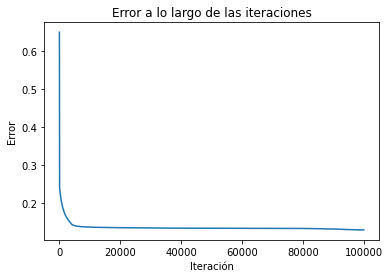

0.8015267175572519

In [19]:
dnn = DenseNN([9, 4, 1], ['l', 's'], 5)
dnn.train( 1e-05, 1e-03, 0)

z = dnn.backpropagation(X_train,y_train)
dnn.step()
errores = []
for i in range(100000):
    error = dnn.backpropagation(X_train,y_train)
    errores.append(error) # Impresion de errores
    dnn.step()

plt.plot(errores)
plt.title('Error a lo largo de las iteraciones')
plt.xlabel('Iteración')
plt.ylabel('Error')
plt.show()

1 - np.abs(np.round(dnn.predict(X_test)) - y_test).sum()/X_test.shape[0] # Error reportado final fuera de red neuronal

En general, esta red consigue una eficacia de al rededor de un %80. Los valores del error, a pesar de que disminuyen bastante, no mejoran demasiado desde cerca de la iteración 10000, por lo que se puede ver del gráfico.

# 8. Aprendizaje
* Pudimos ver como el `backpropagation` ocurre por dentro y se va extendiendo por las matrices de pesos para mejorar las estimaciones.
* Nos quedo mucho más claro como una red neuronal funciona para estimar a partir de datos. Donde literalmente como se ha mencionado en el curso es la búsqueda de una función NO lineal que permita encontrar la reducción de un error.
* Consideramos que a partir de ahora, el funcionamiento de las redes neuronales con otro tipos de arquitectura sera mucho más fácil de comprender.